Created: 2020.07.20

Modified: 2020.07.27

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random
import pandas as pd
from pathlib import Path

import sys
sys.path.append('functions')
import functions32 as f32

# 2D CORONAL - T1

In [3]:
folder_path = Path('/data-10tb/shared/skull/coronal-2d/')

df = pd.read_csv(folder_path/'bias_mask-test-val-coronal-2d.csv')
print(df.shape)
df.head(3)

(425766, 6)


,root,bias_path,image_full_path,mask_full_path,usage_txt,usage
0,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False
1,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False
2,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False


#### Create DataBunch

In [4]:
# item list
il = SegmentationItemList.from_df(df, folder_path, cols='t1_path', convert_mode='L')

In [5]:
# split data
sd = il.split_from_df(col='usage')

In [6]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [7]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [8]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [9]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [10]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [11]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

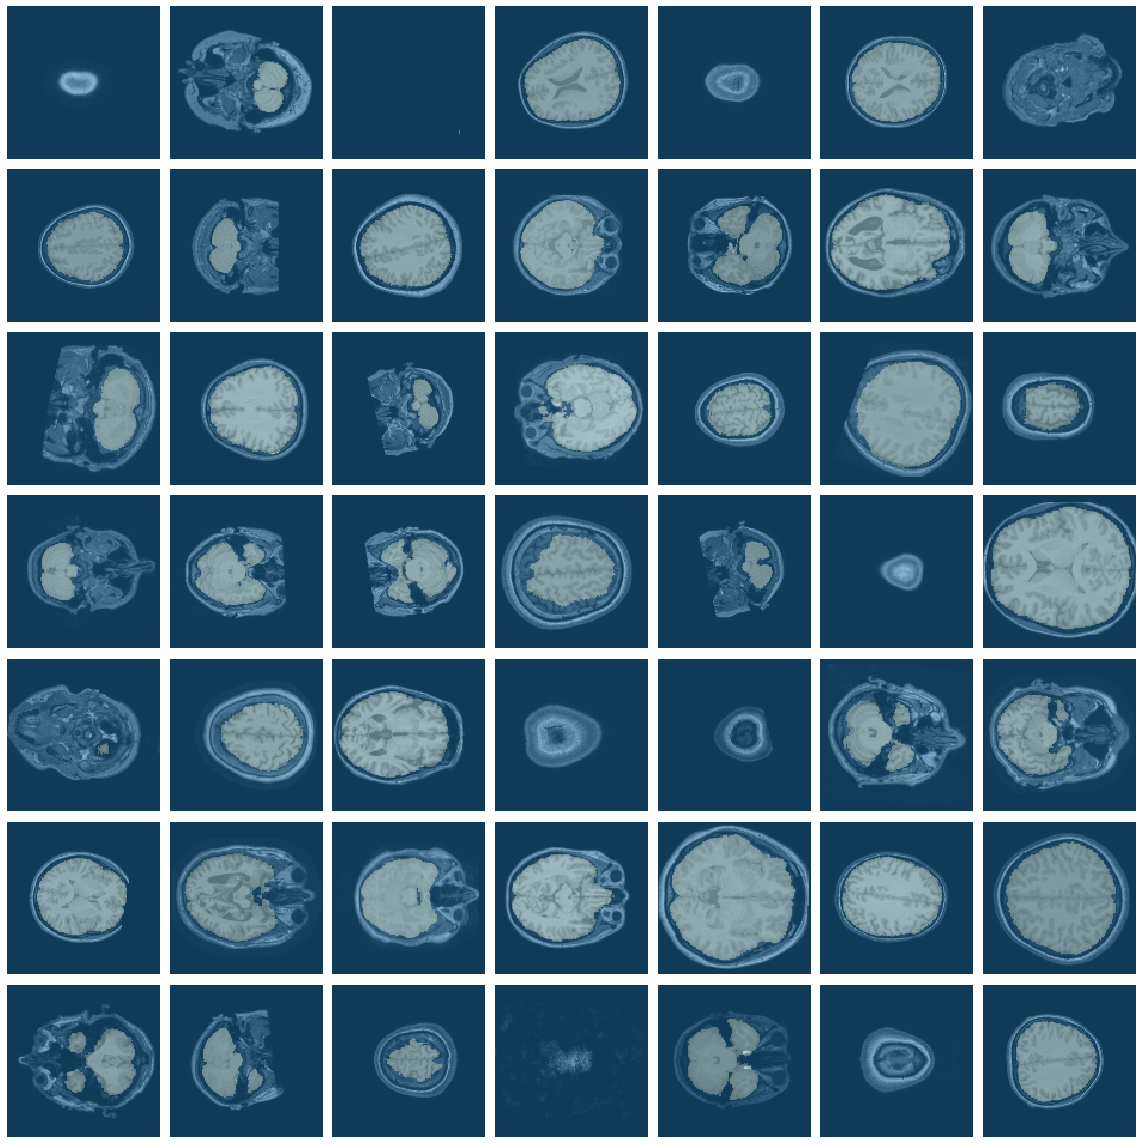

In [12]:
data.show_batch(7, figsize=(16,16))

In [13]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=16
# else:           bs=8
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [14]:
wd=1e-2

In [15]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 7.59E-04


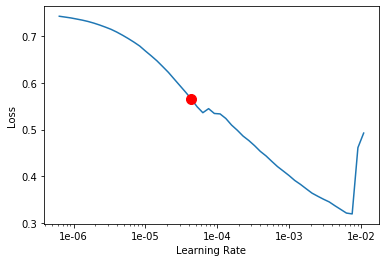

In [16]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

### LR=1e-3

In [20]:
lr=1e-3

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.022482,0.024185,0.927332,44:24
1,0.019372,0.021945,0.933707,1:00:06
2,0.016431,0.022346,0.940095,24:27
3,0.014868,0.022008,0.940431,24:11
4,0.013972,0.022942,0.941360,24:14


In [16]:
# id-trening-axial/freeze-unfreeze/fit-one-cycle-5/lr=1e-5/split-data
save = 0

sname = '01_train-coronal_t1_fr_foc-05_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [17]:
learn.load(sname);

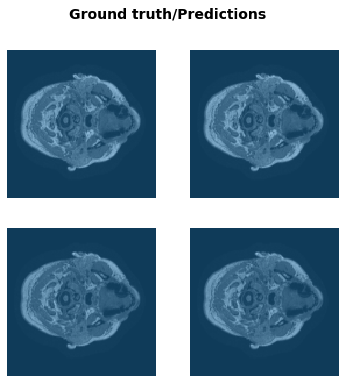

In [18]:
learn.show_results(rows=2, figsize=(6,6))

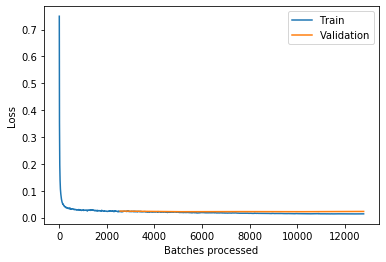

In [25]:
learn.recorder.plot_losses()

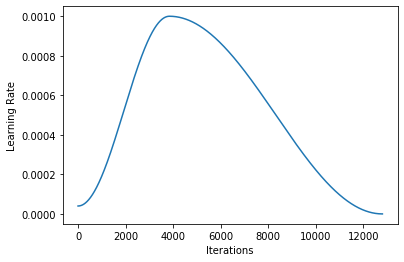

In [26]:
learn.recorder.plot_lr()

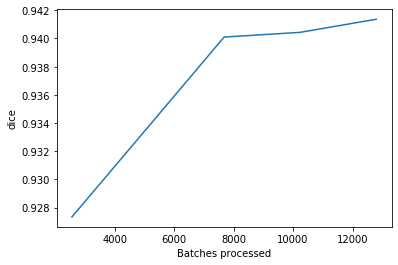

In [27]:
learn.recorder.plot_metrics()

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.015497,0.020978,0.936739,31:46
1,0.015583,0.023624,0.939012,24:10
2,0.014521,0.023600,0.940659,24:10
3,0.013275,0.023831,0.941249,24:10
4,0.013146,0.024106,0.941783,24:12


In [23]:
save = 0

sname = '02_train-coronal_t1_fr_foc-10_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [27]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.013930,0.024561,0.939398,58:04
1,0.014879,0.021378,0.937756,24:13
2,0.013725,0.024004,0.940311,24:11
3,0.012791,0.024235,0.941788,24:12
4,0.012466,0.024713,0.942331,24:13


In [28]:
save = 0

sname = '03_train-coronal_t1_fr_foc-15_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [29]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.013280,0.022842,0.940615,24:14
1,0.013685,0.024374,0.940222,24:13
2,0.012986,0.024009,0.940515,24:18
3,0.012334,0.025540,0.941786,27:32
4,0.012199,0.025593,0.942145,24:14


In [31]:
save = 0

sname = '04_train-coronal_t1_fr_foc-20_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(lr/5,lr/3)

In [36]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.015288,0.024044,0.940648,25:06
1,0.013775,0.022698,0.941543,25:12
2,0.013187,0.022522,0.941856,25:12
3,0.012266,0.024284,0.942135,25:12
4,0.012140,0.024349,0.942544,25:13


In [38]:
save = 0

sname = '05_train-coronal_t1_uf_foc-25_lr-1e3_sp-all'
if save:
    learn.save(sname)